## ✒️ Styling, Libraries, and Helpful Functions

In [0]:
%tensorflow_version 1.x

In [65]:
import time,cv2,math
import pandas as pd,numpy as np
import pylab as pl,keras as ks
import sklearn as sl,tensorflow as tf
from PIL import ImageFile,Image
from keras.datasets import mnist
from keras.layers import Input,Dense,Activation,Reshape
from keras.layers import BatchNormalization,Flatten
from keras.layers import Conv2D,Conv2DTranspose,GlobalMaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam,Nadam
from keras import backend
from keras.layers.advanced_activations import PReLU,LeakyReLU
np.set_printoptions(precision=8); rn=np.random.randint(5000)
from keras import __version__
print('keras version:',__version__)
print('tensorflow version:',tf.__version__)

keras version: 2.3.1
tensorflow version: 1.15.2


In [0]:
def get_batches(images,batch_size):
    current_index=0
    while current_index+batch_size<=images.shape[0]:
        data_batch=images[current_index:current_index+batch_size]
        current_index+=batch_size
        yield data_batch/255-.5 
def images_square_grid(images,mode):
    save_size=math.floor(np.sqrt(images.shape[0]))
    images=(((images-images.min())*255)/\
            (images.max()-images.min())).astype(np.uint8)
    images_in_square=np.reshape(images[:save_size*save_size],
                                (save_size,save_size,images.shape[1],
                                 images.shape[2],images.shape[3]))
    if mode=='L':
        images_in_square=np.squeeze(images_in_square,4)
    new_im=Image.new(mode,(images.shape[1]*save_size,
                           images.shape[2]*save_size))
    for col_i,col_images in enumerate(images_in_square):
        for image_i,image in enumerate(col_images):
            im=Image.fromarray(image, mode)
            new_im.paste(im,(col_i*images.shape[1],
                             image_i*images.shape[2]))
    return new_im

In [0]:
def preprocess(x):    
    x=(x-.5)*2
    return np.clip(x,-1,1)
def deprocess(x):
    x=(x/2+.5)*255
#    np.place(x,x>220,255)
    x=np.clip(x,0,255)
    x=np.uint8(x)
    return x.reshape(28,28)
def latent_samples(n_samples,sample_size):
    return np.random.normal(loc=0,scale=1,
                            size=(n_samples,sample_size))
def trainable(model,trainable):
    for layer in model.layers:
        layer.trainable=trainable
def real_fake_labels(size):
    return np.ones([size,1]),np.zeros([size,1])
def display_images(generated_images):
    n_images=len(generated_images)
    rows=4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))
    for i in range(n_images):
        img=deprocess(generated_images[i])
        pl.subplot(rows,cols,i+1)
        pl.imshow(img,cmap=pl.cm.bone)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()
def display_loss(losses):
    losses=np.array(losses)        
    pl.figure(figsize=(12,5))
    pl.plot(losses.T[0],'-o',c='#196fc6',lw=1,label='Discriminator')
    pl.plot(losses.T[1],'-o',c='crimson',lw=1,label='Generator')
    pl.title("Training Loss Functions"); pl.legend()
def display_loss2(losses,n):
    indices=[i*n for i in range(len(losses)//n)]
    n_losses=np.array(losses)[indices,:]    
    pl.figure(figsize=(12,6))
    pl.plot(n_losses.T[0],'-o',c='#196fc6',lw=1,
            label='Discriminator')
    pl.plot(n_losses.T[1],'-o',c='crimson',lw=1,
            label='Generator')
    pl.title("Training Loss Functions")
    pl.legend(); pl.show()

## ✒️ Data

In [68]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()
n=int(len(x_test)/2)
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
cy_train=ks.utils.to_categorical(y_train,10)
cy_valid=ks.utils.to_categorical(y_valid,10)
cy_test=ks.utils.to_categorical(y_test,10)
x_train.shape,x_valid.shape,x_test.shape

((60000, 28, 28), (5000, 28, 28), (5000, 28, 28))

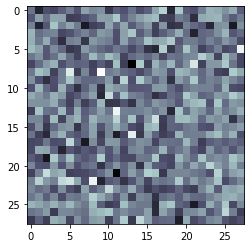

In [69]:
latent_sample784=latent_samples(1,784)
pl.imshow(np.squeeze(latent_sample784).reshape(28,28),
          cmap=pl.cm.bone); pl.show()

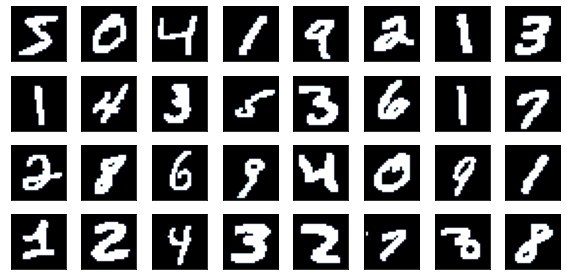

In [70]:
X_train_real=preprocess(x_train)
X_test_real=preprocess(x_test)
display_images(X_train_real[:32])
X_train_real=X_train_real.reshape(-1,784)
X_test_real=X_test_real.reshape(-1,784)

## ✒️ TensorFlow

In [0]:
images=x_train.astype('float32').reshape(-1,28,28,1)
stddev=.01; alpha=0.1
learning_rate=.0002; beta1=.5 
z_dim=128; batch_size=32; epochs=5

In [0]:
def nn_inputs(image_width,image_height,image_channels,z_dim):
    input_real=tf.placeholder(tf.float32,name="Real_Input",
                              shape=[None,image_width,
                                     image_height,image_channels]) # rank 4  
    input_z=tf.placeholder(tf.float32,shape=[None,z_dim],
                           name="Z_Input") # rank 2    
    input_learning_rate=tf.placeholder(tf.float32,shape=[],
                                       name="Learning_Rate") # rank 0    
    return input_real,input_z,input_learning_rate

In [0]:
def nn_discriminator(images,reuse=False,alpha=alpha):
    with tf.variable_scope('discriminator',reuse=reuse):
        # image shape [28,28,1]
        x=tf.layers.conv2d(images,32,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)         
        # input shape [14,14,32]       
        x=tf.layers.conv2d(x,96,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)        
        x=tf.layers.batch_normalization(x,training=True)
        # input shape [7,7,96]        
        x=tf.layers.conv2d(x,128,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)       
        x=tf.layers.batch_normalization(x,training=True)
        # input shape [4,4,128]       
        x=tf.reshape(x,(-1,4*4*128))        
        discriminator_logits=tf.layers.dense(x,1)
        discriminator_outputs=tf.sigmoid(discriminator_logits)        
    return discriminator_outputs,discriminator_logits

In [0]:
def nn_generator(z,out_channel_dim,is_train=True,alpha=alpha):
    with tf.variable_scope('generator',reuse=(not is_train)):        
        x=tf.layers.dense(z,7*7*128)
        x=tf.reshape(x,(-1,7,7,128))
        x=tf.maximum(x*alpha,x)          
        x=tf.layers.batch_normalization(x,training=is_train)      
        # input shape [7,7,128]       
        x=tf.layers.conv2d_transpose(x,96,5,strides=2,padding='same',
                                     kernel_initializer=\
                                     tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)          
        x=tf.layers.batch_normalization(x,training=is_train)
        # input shape [14,14,96]
        x=tf.layers.conv2d_transpose(x,32,5,strides=2,padding='same',
                                     kernel_initializer=\
                                     tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)              
        x=tf.layers.batch_normalization(x,training=is_train)
        # input shape [28,28,32]        
        generator_logits=\
        tf.layers.conv2d_transpose(x,out_channel_dim,3,strides=1,padding='same', 
                                   kernel_initializer=\
                                   tf.random_normal_initializer(stddev=stddev))
        # input shape [28,28,1]         
        generator_outputs=tf.tanh(generator_logits)   
    return generator_outputs    

In [0]:
def nn_loss(input_real,input_z,out_channel_dim,
            alpha=alpha,index="leaky_relu"):    
    if index=="relu":
        img_generator=generator(input_z,out_channel_dim,
                                is_train=True,alpha=alpha)
        real_outputs,real_logits=\
        discriminator(input_real,reuse=False,alpha=alpha)
        generator_outputs,generator_logits=\
        discriminator(img_generator,reuse=True,alpha=alpha)
    elif index=="leaky_relu":
        img_generator=nn_generator(input_z,out_channel_dim,
                                   is_train=True,alpha=alpha)
        real_outputs,real_logits=\
        nn_discriminator(input_real,alpha=alpha)
        generator_outputs,generator_logits=\
        nn_discriminator(img_generator,reuse=True,alpha=alpha)          
    real_labels=tf.ones_like(real_outputs)*(1-alpha)
    zeros_labels=tf.zeros_like(generator_outputs)
    ones_labels=tf.ones_like(generator_outputs)
    real_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=real_logits,
                                       labels=real_labels))
    zeros_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=generator_logits,
                                       labels=zeros_labels))
    ones_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=generator_logits,
                                       labels=ones_labels))
    return real_loss+zeros_loss,ones_loss

In [0]:
def nn_optimizer(discriminator_loss,generator_loss,
                 learning_rate,beta1):
    trainable_variables=tf.trainable_variables()
    discriminator_trainable_variables=\
    [v for v in trainable_variables 
     if v.name.startswith('discriminator')]
    generator_trainable_variables=\
    [v for v in trainable_variables 
     if v.name.startswith('generator')]   
    update_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops=\
    [u for u in update_ops 
     if u.name.startswith('discriminator')]
    generator_update_ops=\
    [u for u in update_ops 
     if u.name.startswith('generator')]
    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations=\
        tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)\
        .minimize(discriminator_loss,
                  var_list=discriminator_trainable_variables)
    with tf.control_dependencies(generator_update_ops):
        generator_training_operations=\
        tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)\
        .minimize(generator_loss,
                  var_list=generator_trainable_variables)           
    return discriminator_training_operations,generator_training_operations

In [0]:
def train(images,epoch_count,batch_size,
          z_dim,learning_rate,beta1, 
          data_shape,data_image_mode,
          print_step,show_step):    
    input_real,input_z,input_learning_rate = \
    nn_inputs(data_shape[1],data_shape[2],
              data_shape[3],z_dim)   
    discriminator_loss,generator_loss=\
    nn_loss(input_real,input_z,data_shape[3],
            alpha=alpha,index="leaky_relu")  
    discriminator_training_operations,generator_training_operations=\
    nn_optimizer(discriminator_loss,generator_loss,
                 learning_rate,beta1)   
    train_step=0; DTL,GTL=[],[]    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(images,batch_size):
                train_step+=1
                batch_images*=2.0                
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))               
                _=sess.run(discriminator_training_operations, 
                           feed_dict={input_real:batch_images,
                                      input_z:batch_z})
                _=sess.run(generator_training_operations, 
                           feed_dict={input_z:batch_z})
                if train_step%print_step==0:
                    discriminator_training_loss=\
                    discriminator_loss.eval({input_real:batch_images,
                                             input_z:batch_z})
                    generator_training_loss=\
                    generator_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}| Step {}|"\
                          .format(epoch_i+1,epochs,train_step),
                          "Discriminator Loss:{:.5f}|"\
                          .format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|"\
                          .format(generator_training_loss),
                          "Discriminator Loss>Generator Loss: {}"\
                          .format(discriminator_training_loss>generator_training_loss))                   
                    DTL.append(discriminator_training_loss) 
                    GTL.append(generator_training_loss)                    
                    if discriminator_training_loss>generator_training_loss:
                        cmap=None if data_image_mode=='RGB' else 'gray'
                        z_dim=input_z.get_shape().as_list()[-1]
                        example_z=np.random.uniform(-1,1,size=[25,z_dim])
                        samples=sess.run(nn_generator(input_z,data_shape[3],False),
                                         feed_dict={input_z:example_z})
                        images_grid=images_square_grid(samples,data_image_mode)
                        pl.figure(figsize=(5,5))
                        pl.imshow(np.array(images_grid),cmap=cmap); pl.show()                            
    pl.figure(figsize=(12,6))
    pl.plot(DTL,'-o',c='#196fc6',label='Discriminator')
    pl.plot(GTL,'-o',c='crimson',label='Generator')
    pl.legend(); pl.title('Loss Function'); pl.show()

In [78]:
with tf.Graph().as_default():
    train(images,epochs,batch_size, 
          z_dim,learning_rate,beta1, 
          images.shape,"L",100,1000)

Output hidden; open in https://colab.research.google.com to view.

## ✒️ Keras GAN

In [0]:
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):    
    ks.backend.clear_session()    
    generator=Sequential([Dense(g_hidden_size,input_shape=(sample_size,)),
                          LeakyReLU(alpha=leaky_alpha),
                          Dense(784),Activation('tanh')], 
                         name='generator')    
    discriminator=Sequential([Dense(d_hidden_size,input_shape=(784,)),
                              LeakyReLU(alpha=leaky_alpha),
                              Dense(1),Activation('sigmoid')], 
                             name='discriminator')        
    gan=Sequential([generator,discriminator])    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), 
                          loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), 
                loss='binary_crossentropy')   
    return gan,generator,discriminator

In [0]:
sample_size     = 128     
g_hidden_size   = 784     # generator
d_hidden_size   = 128     # discriminator
leaky_alpha     = .02
g_learning_rate = .0001  # generator
d_learning_rate = .001  # discriminator
epochs          = 200
batch_size      = 64      
valid_size      = 16     
smooth          = .1

In [0]:
y_train_real,y_train_fake=real_fake_labels(batch_size)
y_valid_real,y_valid_fake=real_fake_labels(valid_size)
gan,generator,discriminator=\
simple_GAN(sample_size,g_hidden_size,d_hidden_size,
           leaky_alpha,g_learning_rate,d_learning_rate)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 10/200 | Discriminator Loss: 0.4021 | Generator Loss: 3.8057 | DL > GL: False
Epoch: 20/200 | Discriminator Loss: 0.9256 | Generator Loss: 2.4936 | DL > GL: False
Epoch: 30/200 | Discriminator Loss: 0.4983 | Generator Loss: 2.9602 | DL > GL: False
Epoch: 40/200 | Discriminator Loss: 0.4719 | Generator Loss: 2.7684 | DL > GL: False
Epoch: 50/200 | Discriminator Loss: 0.7985 | Generator Loss: 2.1735 | DL > GL: False
Epoch: 60/200 | Discriminator Loss: 1.1757 | Generator Loss: 2.0523 | DL > GL: False
Epoch: 70/200 | Discriminator Loss: 0.9974 | Generator Loss: 1.6744 | DL > GL: False
Epoch: 80/200 | Discriminator Loss: 1.0034 | Generator Loss: 1.8723 | DL > GL: False
Epoch: 90/200 | Discriminator Loss: 0.9574 | Generator Loss: 1.3155 | DL > GL: False
Epoch: 100/200 | Discriminator Loss: 1.0951 | Generator Loss: 1.7229 | DL > GL: False
Epoch: 110/200 | Discriminator Loss: 0.7934 | Generator Loss: 1.6170 | DL > GL: False
Epoch: 120/200 | Discriminator Loss: 1.1202 | Generator Loss: 1

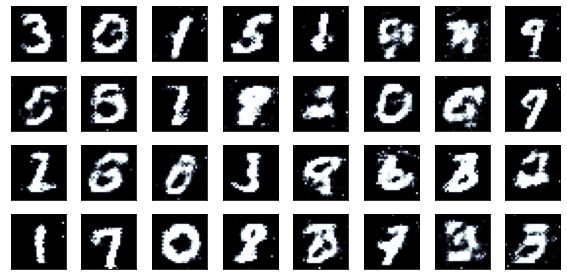

Epoch: 130/200 | Discriminator Loss: 1.0275 | Generator Loss: 1.1862 | DL > GL: False
Epoch: 140/200 | Discriminator Loss: 1.0121 | Generator Loss: 1.5663 | DL > GL: False
Epoch: 150/200 | Discriminator Loss: 1.1312 | Generator Loss: 1.3274 | DL > GL: False
Epoch: 160/200 | Discriminator Loss: 0.9642 | Generator Loss: 1.3699 | DL > GL: False
Epoch: 170/200 | Discriminator Loss: 1.2036 | Generator Loss: 1.1136 | DL > GL: True


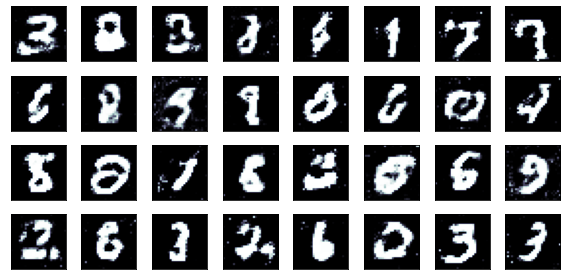

Epoch: 180/200 | Discriminator Loss: 1.4201 | Generator Loss: 1.2215 | DL > GL: True


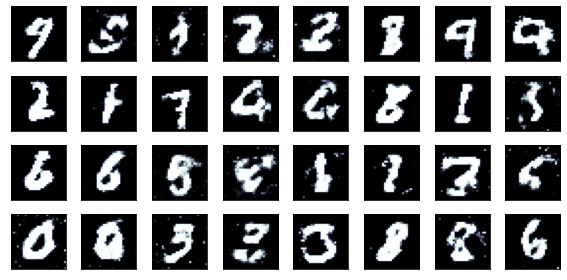

Epoch: 190/200 | Discriminator Loss: 0.9914 | Generator Loss: 1.2725 | DL > GL: False
Epoch: 200/200 | Discriminator Loss: 0.9742 | Generator Loss: 1.0804 | DL > GL: False


In [62]:
losses=[]
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real images
        X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]        
        # latent samples and generated letter images
        batch_latent_samples=latent_samples(batch_size,sample_size)
        X_batch_fake=generator.predict_on_batch(batch_latent_samples)        
        # train the discriminator to detect real and fake images
        trainable(discriminator,True)
        discriminator.train_on_batch(X_batch_real,y_train_real*(1.-smooth))
        discriminator.train_on_batch(X_batch_fake,y_train_fake)
        # train the generator via GAN
        trainable(discriminator,False)
        gan.train_on_batch(batch_latent_samples,y_train_real)    
    # evaluate
    X_valid_real=X_test_real[np.random.choice(len(X_test_real), 
                                              valid_size,replace=False)]    
    valid_latent_samples=latent_samples(valid_size,sample_size)
    X_valid_fake=generator.predict_on_batch(valid_latent_samples)
    d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
    d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
    g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real)     
    losses.append((d_loss,g_loss))
    st="Epoch: %d/%d | Discriminator Loss: %.4f | "+\
       "Generator Loss: %.4f | DL > GL: %s"
    if (e+1)%int(10)==0:
        print(st%((e+1,epochs,d_loss,g_loss,d_loss>g_loss)))
        if ((g_loss<1.4) and (d_loss>g_loss)):
            latent_examples=latent_samples(32,sample_size)
            generated_digits=generator.predict(latent_examples)
            display_images(generated_digits)

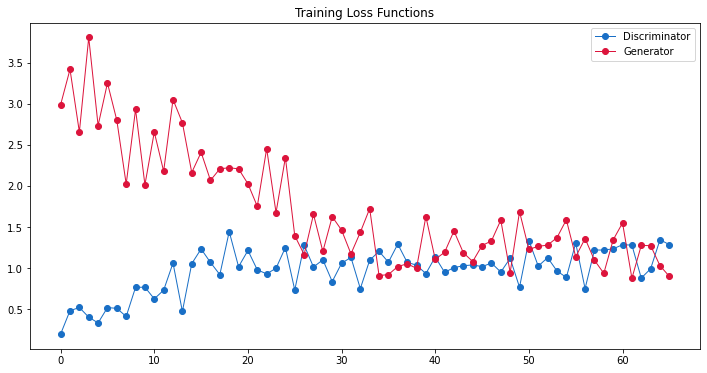

In [63]:
 display_loss2(losses,3)

## ✒️ Keras DCGAN

In [0]:
X_train_real=X_train_real.reshape(-1,28,28,1)
X_test_real=X_test_real.reshape(-1,28,28,1)

In [42]:
def dcgan_generator(input_size,leaky_alpha):
    return Sequential([
        Dense(784,input_shape=(input_size,)),
        Reshape(target_shape=(7,7,16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
 #       Conv2DTranspose(64,kernel_size=5,strides=2,padding='same'),
 #       BatchNormalization(), 
 #       LeakyReLU(alpha=leaky_alpha),    
        Conv2DTranspose(32,kernel_size=7,strides=2,padding='same'),
        BatchNormalization(), 
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(1,kernel_size=7,strides=2,padding='same'),
        Activation('tanh')])
dcgan_generator_example=dcgan_generator(784,.01)
dcgan_generator_example.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 32)        25120     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 32)       

In [43]:
def dcgan_discriminator(leaky_alpha):
    return Sequential([        
        Conv2D(32,kernel_size=7,strides=2,
               padding='same',input_shape=(28,28,1)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
#        Conv2D(64,kernel_size=5,strides=2,padding='same'),   
#        BatchNormalization(),
#        LeakyReLU(alpha=leaky_alpha),
        Conv2D(16,kernel_size=7,strides=2,padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),        
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),        
        Dense(1),
        Activation('sigmoid')])
dcgan_discriminator_example=dcgan_discriminator(.01)
dcgan_discriminator_example.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        1600      
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          25104     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)              

In [0]:
def dcgan(sample_size,leaky_alpha,
          g_learning_rate,g_beta_1,
          d_learning_rate,d_beta_1):
    backend.clear_session()    
    generator=dcgan_generator(sample_size,leaky_alpha)
    discriminator=dcgan_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate,beta_1=d_beta_1), 
                          loss='binary_crossentropy')
    gan=Sequential([generator,discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate,beta_1=g_beta_1), 
                loss='binary_crossentropy')    
    return gan,generator,discriminator  

In [0]:
def dcgan_train(g_learning_rate,g_beta_1,
                d_learning_rate,d_beta_1,
                leaky_alpha,smooth=.1,
                sample_size=128,epochs=100,
                batch_size=128,valid_size=32,
                show_details=True):    
    # labels for the batch size and the valid size
    y_train_real,y_train_fake=real_fake_labels(batch_size)
    y_valid_real,y_valid_fake=real_fake_labels(valid_size)
    # create a GAN, a generator and a discriminator
    gan,generator,discriminator=dcgan(sample_size,leaky_alpha,
                                      g_learning_rate,g_beta_1,
                                      d_learning_rate,d_beta_1)
    losses=[]
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real=X_train_real[i*batch_size:(i+1)*batch_size]
            # latent samples and the generated digit images
            batch_latent_samples=latent_samples(batch_size,sample_size)
            X_batch_fake=generator.predict_on_batch(batch_latent_samples)
            # train the discriminator to detect real and fake images
            trainable(discriminator,True)
            discriminator.train_on_batch(X_batch_real,y_train_real*(1-smooth))
            discriminator.train_on_batch(X_batch_fake,y_train_fake)
            # train the generator via GAN
            trainable(discriminator,False)
            gan.train_on_batch(batch_latent_samples,y_train_real)
        # evaluate
        X_valid_real=X_test_real[np.random.choice(len(X_test_real),
                                                  valid_size,replace=False)]
        valid_latent_samples=latent_samples(valid_size,sample_size)
        X_valid_fake=generator.predict_on_batch(valid_latent_samples)
        d_loss=discriminator.test_on_batch(X_valid_real,y_valid_real)
        d_loss+=discriminator.test_on_batch(X_valid_fake,y_valid_fake)
        g_loss=gan.test_on_batch(valid_latent_samples,y_valid_real) 
        losses.append((d_loss,g_loss))
        print("Epoch:{:>3}/{} | Discriminator Loss:{:>7.4f} | Generator Loss:{:>7.4f}"\
              .format(e+1,epochs,d_loss,g_loss))        
        if show_details and g_loss<1.8 and g_loss>.8: display_images(X_valid_fake)           
    if show_details: display_loss(losses)        
    return generator

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 | Discriminator Loss: 5.2802 | Generator Loss: 0.0914
Epoch:  2/100 | Discriminator Loss: 4.9200 | Generator Loss: 1.8116
Epoch:  3/100 | Discriminator Loss: 7.1359 | Generator Loss: 4.7506
Epoch:  4/100 | Discriminator Loss: 2.4303 | Generator Loss: 3.2511
Epoch:  5/100 | Discriminator Loss: 5.9770 | Generator Loss: 3.9325
Epoch:  6/100 | Discriminator Loss: 2.1199 | Generator Loss: 2.3780
Epoch:  7/100 | Discriminator Loss: 2.4583 | Generator Loss: 3.1577
Epoch:  8/100 | Discriminator Loss: 3.0126 | Generator Loss: 3.7951
Epoch:  9/100 | Discriminator Loss: 2.7631 | Generator Loss: 4.3620
Epoch: 10/100 | Discriminator Loss: 2.7145 | Generator Loss: 2.9673
Epoch: 11/100 | Discriminator Loss: 3.1659 | Generator Loss: 3.2829
Epoch: 12/100 | Discriminator Loss: 6.8178 | Generator Loss: 6.5546
Epoch: 13/100 | Discriminator Loss: 2.8839 | Generator Loss: 3.3695
Epoch: 14/100 | Discriminator Loss: 6.6289 | Generator Loss: 5.9772
Epoch: 15/100 | Discriminator Loss: 2.1610 | Gen

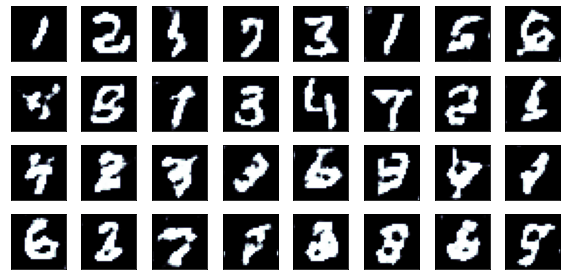

Epoch: 19/100 | Discriminator Loss: 1.7468 | Generator Loss: 1.8719
Epoch: 20/100 | Discriminator Loss: 3.8962 | Generator Loss: 4.8631
Epoch: 21/100 | Discriminator Loss: 5.2194 | Generator Loss: 4.8681
Epoch: 22/100 | Discriminator Loss: 7.8593 | Generator Loss: 7.3576
Epoch: 23/100 | Discriminator Loss:12.6601 | Generator Loss:11.7692
Epoch: 24/100 | Discriminator Loss:20.1301 | Generator Loss:16.6511
Epoch: 25/100 | Discriminator Loss: 2.1357 | Generator Loss: 2.9207
Epoch: 26/100 | Discriminator Loss: 4.6475 | Generator Loss: 3.5299
Epoch: 27/100 | Discriminator Loss: 7.8573 | Generator Loss: 7.7177
Epoch: 28/100 | Discriminator Loss: 5.8261 | Generator Loss: 5.8222
Epoch: 29/100 | Discriminator Loss:18.6755 | Generator Loss:18.8386
Epoch: 30/100 | Discriminator Loss: 3.1943 | Generator Loss: 3.3495
Epoch: 31/100 | Discriminator Loss:10.7541 | Generator Loss: 9.5103
Epoch: 32/100 | Discriminator Loss: 9.3337 | Generator Loss: 8.9009
Epoch: 33/100 | Discriminator Loss: 8.9921 | Gen

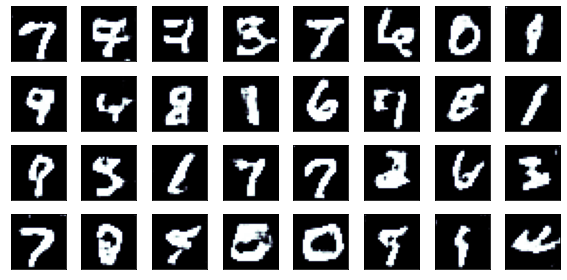

Epoch: 38/100 | Discriminator Loss: 1.2935 | Generator Loss: 1.6984


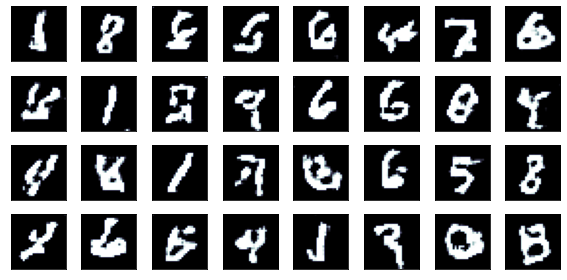

Epoch: 39/100 | Discriminator Loss:10.5996 | Generator Loss: 9.2487
Epoch: 40/100 | Discriminator Loss: 7.8223 | Generator Loss: 7.0227
Epoch: 41/100 | Discriminator Loss: 2.6723 | Generator Loss: 3.1353
Epoch: 42/100 | Discriminator Loss: 5.8162 | Generator Loss: 5.8030
Epoch: 43/100 | Discriminator Loss: 1.9132 | Generator Loss: 2.5357
Epoch: 44/100 | Discriminator Loss: 2.2115 | Generator Loss: 2.6445
Epoch: 45/100 | Discriminator Loss: 1.2684 | Generator Loss: 1.9465
Epoch: 46/100 | Discriminator Loss: 2.4027 | Generator Loss: 3.0155
Epoch: 47/100 | Discriminator Loss: 2.7324 | Generator Loss: 3.1138
Epoch: 48/100 | Discriminator Loss: 3.6665 | Generator Loss: 4.2504
Epoch: 49/100 | Discriminator Loss: 5.6418 | Generator Loss: 4.8262
Epoch: 50/100 | Discriminator Loss: 2.7112 | Generator Loss: 3.1025
Epoch: 51/100 | Discriminator Loss: 3.7970 | Generator Loss: 5.0821
Epoch: 52/100 | Discriminator Loss: 2.7782 | Generator Loss: 3.2760
Epoch: 53/100 | Discriminator Loss: 1.3002 | Gen

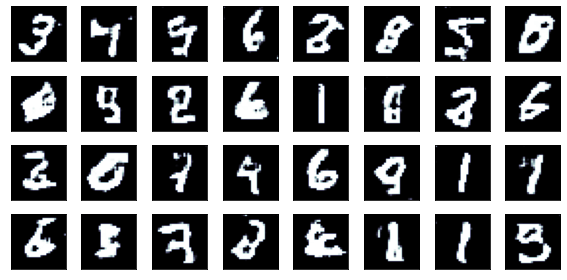

Epoch: 54/100 | Discriminator Loss: 9.4082 | Generator Loss:10.4237
Epoch: 55/100 | Discriminator Loss: 9.5462 | Generator Loss:10.2626
Epoch: 56/100 | Discriminator Loss: 1.3303 | Generator Loss: 1.9028
Epoch: 57/100 | Discriminator Loss: 3.1396 | Generator Loss: 3.0529
Epoch: 58/100 | Discriminator Loss: 2.0689 | Generator Loss: 2.4865
Epoch: 59/100 | Discriminator Loss: 1.7724 | Generator Loss: 2.4717
Epoch: 60/100 | Discriminator Loss: 3.6397 | Generator Loss: 3.7716
Epoch: 61/100 | Discriminator Loss: 2.6614 | Generator Loss: 2.9392
Epoch: 62/100 | Discriminator Loss: 1.9051 | Generator Loss: 2.9118
Epoch: 63/100 | Discriminator Loss: 2.2744 | Generator Loss: 2.8052
Epoch: 64/100 | Discriminator Loss: 3.4052 | Generator Loss: 4.1948
Epoch: 65/100 | Discriminator Loss: 1.9810 | Generator Loss: 2.0894
Epoch: 66/100 | Discriminator Loss: 1.9218 | Generator Loss: 2.2178
Epoch: 67/100 | Discriminator Loss: 1.6143 | Generator Loss: 2.0205
Epoch: 68/100 | Discriminator Loss: 5.1861 | Gen

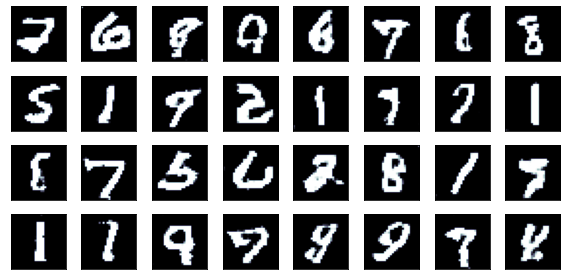

Epoch: 85/100 | Discriminator Loss: 1.6273 | Generator Loss: 2.0604
Epoch: 86/100 | Discriminator Loss: 1.6771 | Generator Loss: 1.9900
Epoch: 87/100 | Discriminator Loss: 1.8012 | Generator Loss: 2.2104
Epoch: 88/100 | Discriminator Loss: 3.0670 | Generator Loss: 3.4164
Epoch: 89/100 | Discriminator Loss: 2.5377 | Generator Loss: 3.3348
Epoch: 90/100 | Discriminator Loss: 1.3594 | Generator Loss: 1.5580


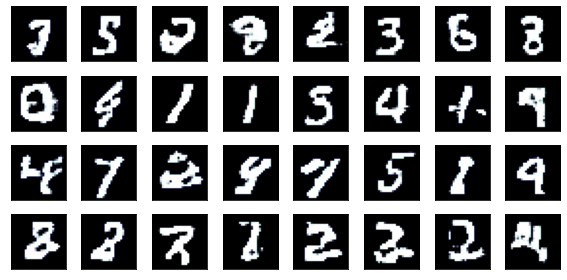

Epoch: 91/100 | Discriminator Loss: 1.3120 | Generator Loss: 1.7456


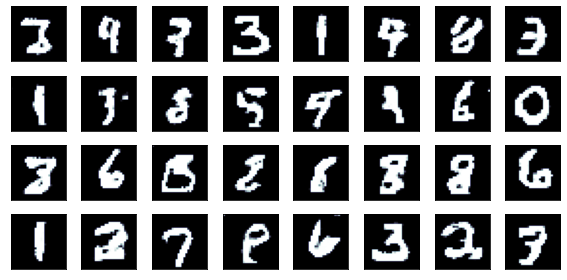

Epoch: 92/100 | Discriminator Loss: 1.2849 | Generator Loss: 2.1540
Epoch: 93/100 | Discriminator Loss: 1.4367 | Generator Loss: 2.8092
Epoch: 94/100 | Discriminator Loss: 1.4254 | Generator Loss: 1.8357
Epoch: 95/100 | Discriminator Loss: 1.3142 | Generator Loss: 2.5050
Epoch: 96/100 | Discriminator Loss: 1.5111 | Generator Loss: 1.9482
Epoch: 97/100 | Discriminator Loss: 1.4126 | Generator Loss: 2.1667
Epoch: 98/100 | Discriminator Loss: 3.4298 | Generator Loss: 3.9516
Epoch: 99/100 | Discriminator Loss: 3.1278 | Generator Loss: 3.6578
Epoch:100/100 | Discriminator Loss: 1.6593 | Generator Loss: 2.0741


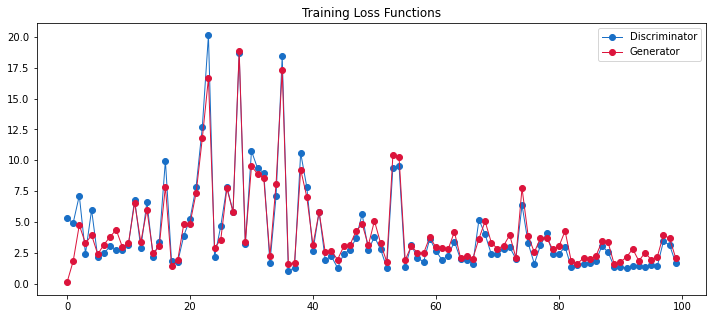

In [46]:
dcgan_train(g_learning_rate=.0001,g_beta_1=.8, 
            d_learning_rate=.001,d_beta_1=.8, 
            leaky_alpha=.01);